In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_curve, auc,confusion_matrix, classification_report, log_loss

# ignore warnings in the output
import warnings

warnings.filterwarnings("ignore")

In [3]:
# 🔹 Step 1: Load Data
df = pd.read_csv("/kaggle/input/iot-final-dataset/IotFinalDataset.csv")
X = df.drop(columns=["Label"])  # Features
y = df["Label"]  # Target

In [4]:
# 🔹 Step 2: Encode Class Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts labels into numbers

In [5]:
# 🔹 Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [6]:
# 🔹 Step 4: Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# 🔹 Step 5: One-Hot Encode y_train and y_test
encoder = OneHotEncoder(sparse_output=False)
y_train_bin = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_bin = encoder.transform(y_test.reshape(-1, 1))

In [8]:
# 🔹 Step 6: Train Model with `CalibratedClassifierCV`
sgd = SGDClassifier(
    loss="log_loss", random_state=42
)  # Use 'log_loss' for probability support
sgd_calibrated = CalibratedClassifierCV(sgd, cv=5)  # Enables probability estimation
sgd_calibrated.fit(X_train_scaled, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=SGDClassifier(loss='log_loss',
                                               random_state=42))

In [9]:
# 🔹 Step 7: Predict and Evaluate
y_pred = sgd_calibrated.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8708


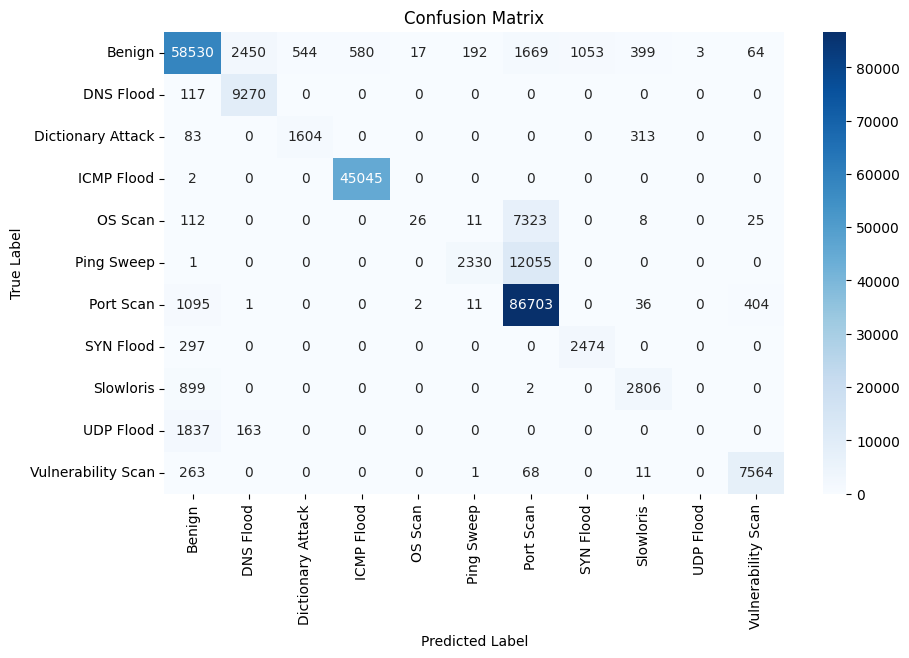

In [13]:
# 🔹 Step 8: Confusion Matrix 📊
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# 🔹 Step 9: Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Classification Report:
                     precision    recall  f1-score   support

            Benign       0.93      0.89      0.91     65501
         DNS Flood       0.78      0.99      0.87      9387
 Dictionary Attack       0.75      0.80      0.77      2000
        ICMP Flood       0.99      1.00      0.99     45047
           OS Scan       0.58      0.00      0.01      7505
        Ping Sweep       0.92      0.16      0.28     14386
         Port Scan       0.80      0.98      0.88     88252
         SYN Flood       0.70      0.89      0.79      2771
         Slowloris       0.79      0.76      0.77      3707
         UDP Flood       0.00      0.00      0.00      2000
Vulnerability Scan       0.94      0.96      0.95      7907

          accuracy                           0.87    248463
         macro avg       0.74      0.68      0.66    248463
      weighted avg       0.86      0.87      0.84    248463



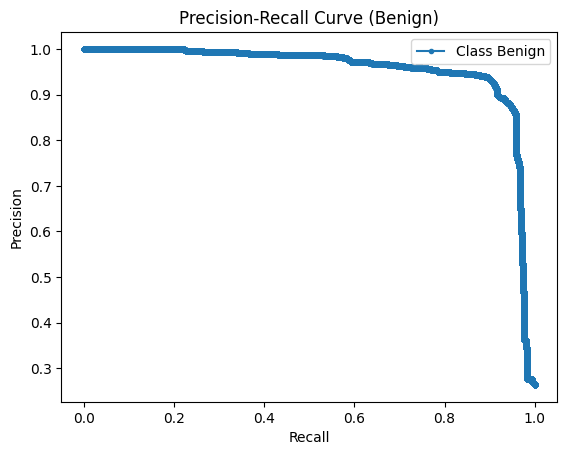

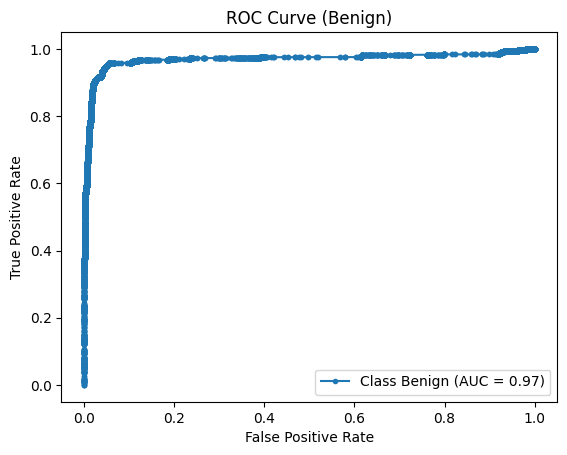

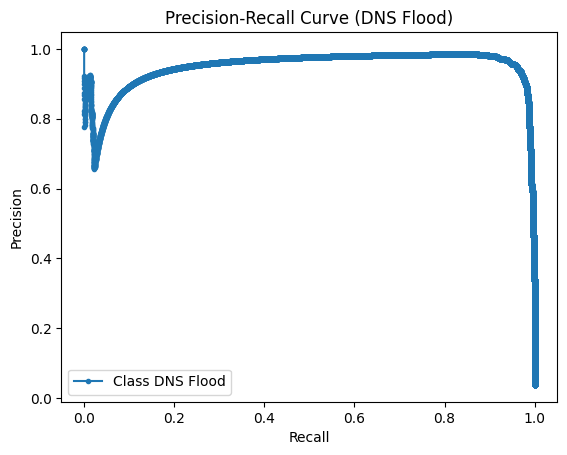

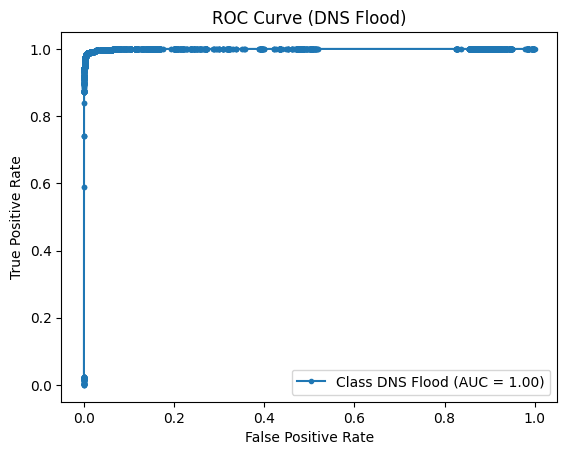

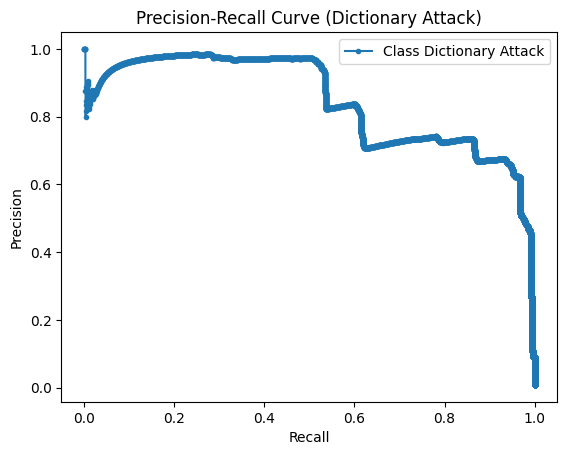

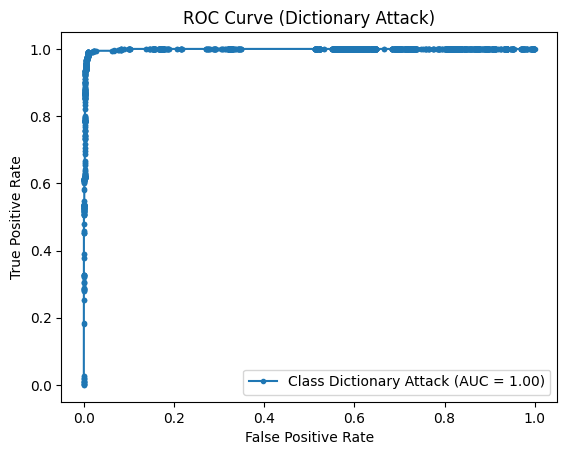

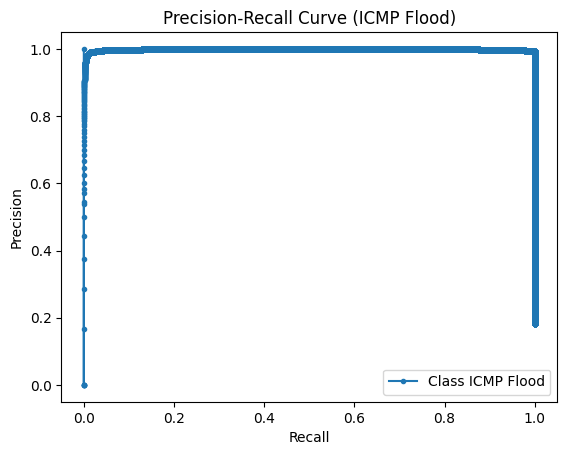

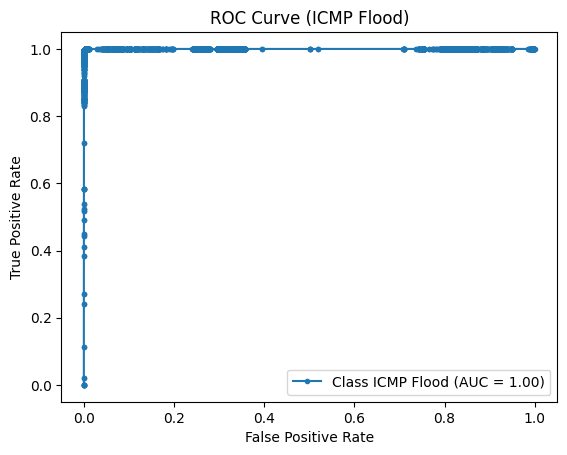

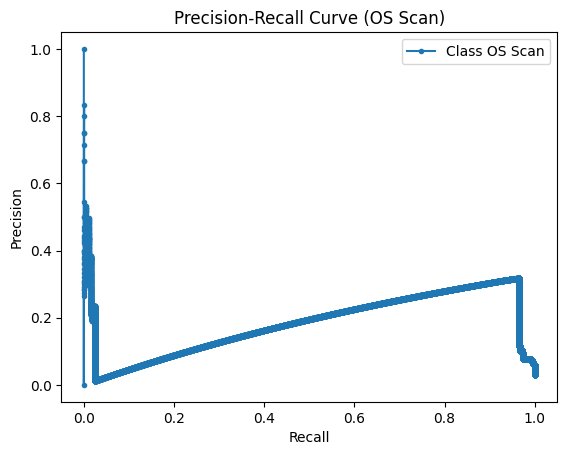

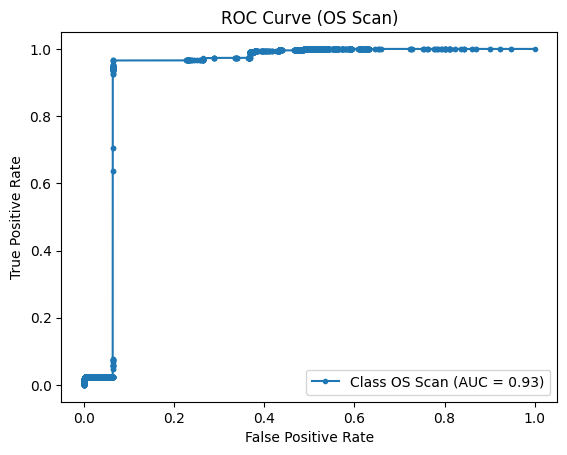

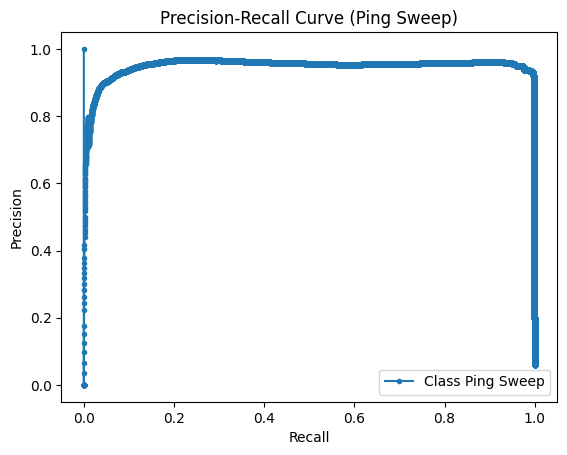

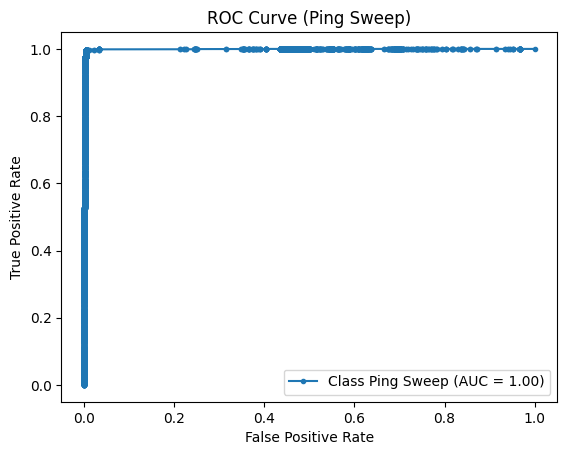

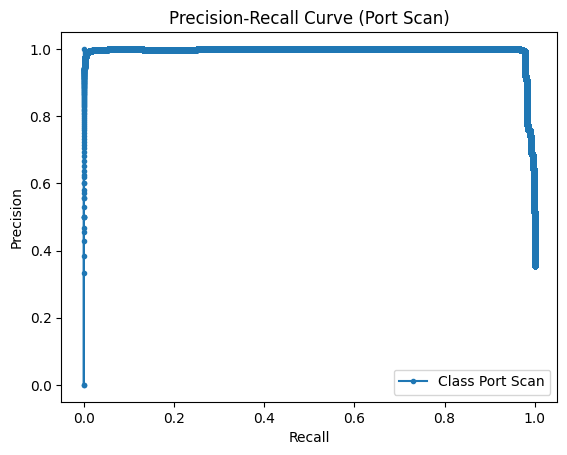

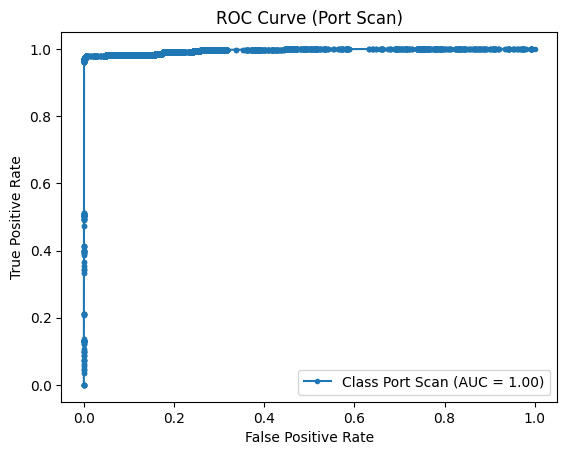

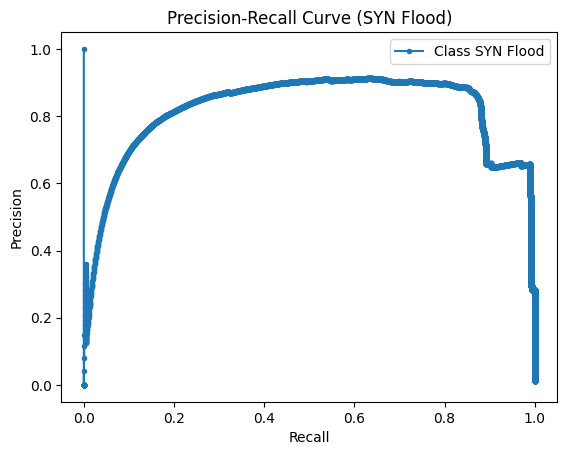

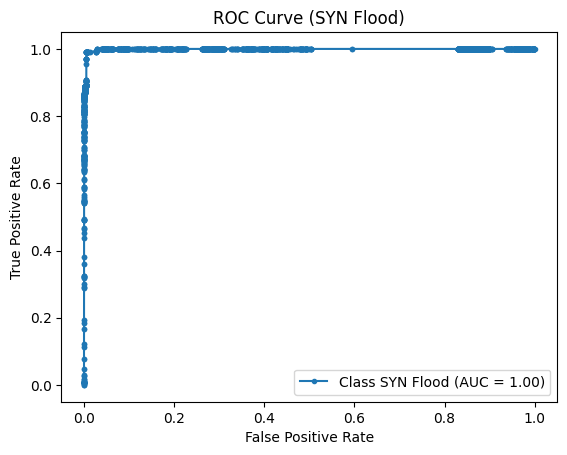

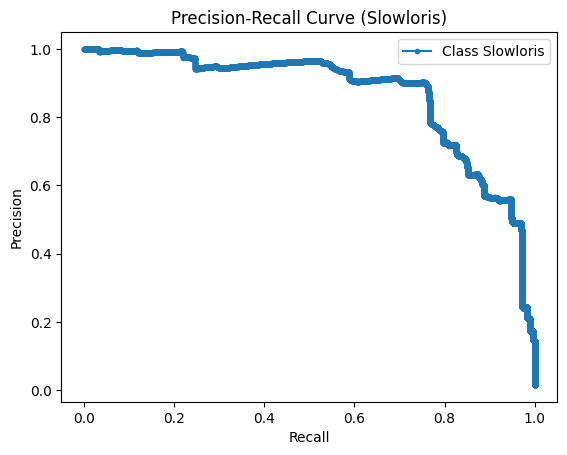

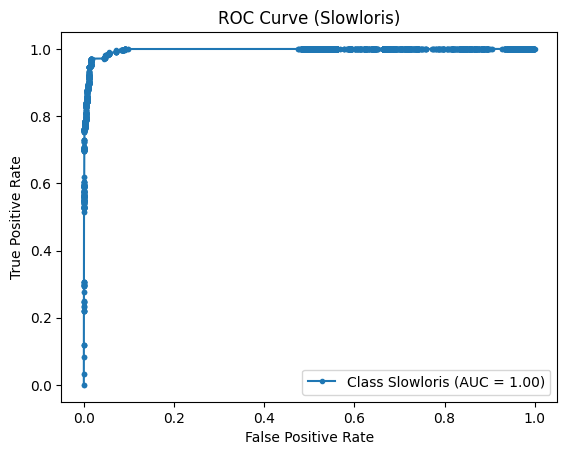

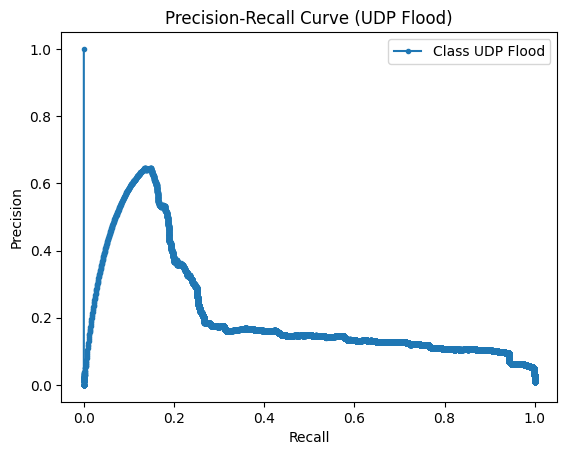

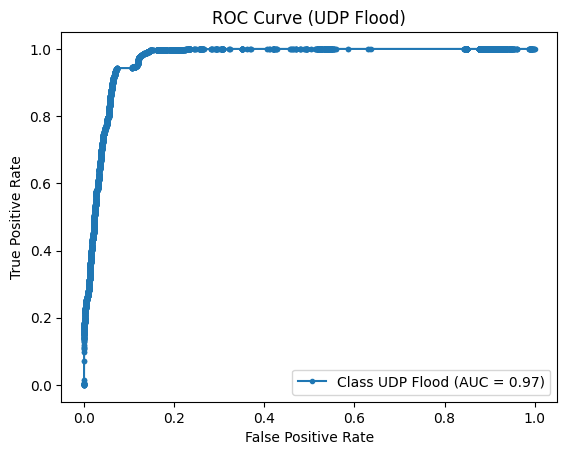

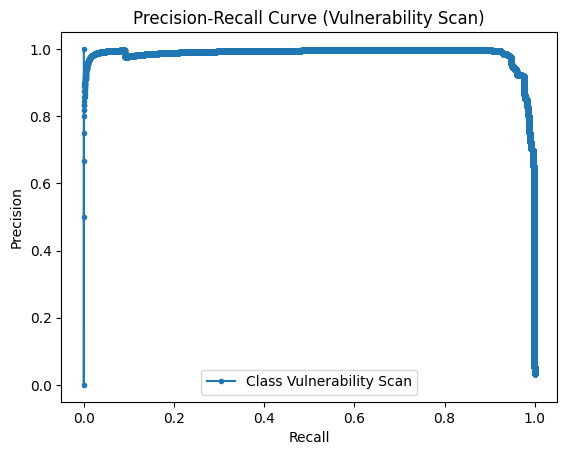

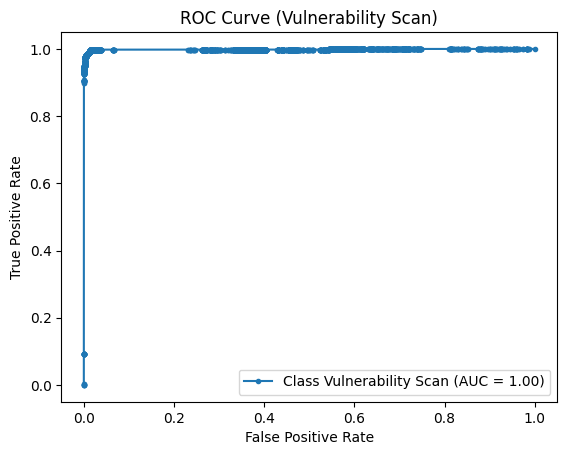

In [16]:
# 🔹 Step 10: Predict Probabilities for Precision-Recall & ROC Curves
y_prob = sgd_calibrated.predict_proba(X_test_scaled)

for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)

    # 📊 Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, marker=".", label=f"Class {class_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({class_name})")
    plt.legend()
    plt.show()

    # 📊 ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, marker=".", label=f"Class {class_name} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve ({class_name})")
    plt.legend()
    plt.show()

Log Loss: 0.4705


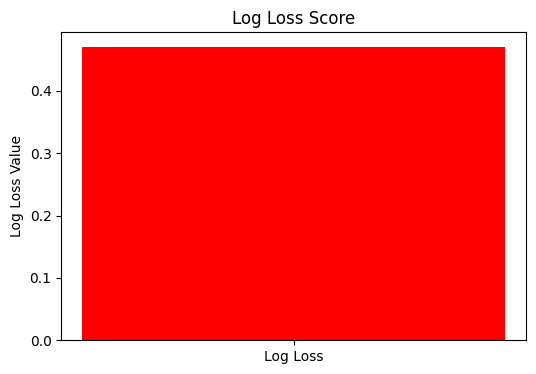

In [17]:
# 🔹 Step 11: Log Loss 📉
logloss = log_loss(y_test_bin, y_prob)
print(f"Log Loss: {logloss:.4f}")

# 📊 Log Loss Bar Plot
plt.figure(figsize=(6, 4))
plt.bar(["Log Loss"], [logloss], color="red")
plt.ylabel("Log Loss Value")
plt.title("Log Loss Score")
plt.show()

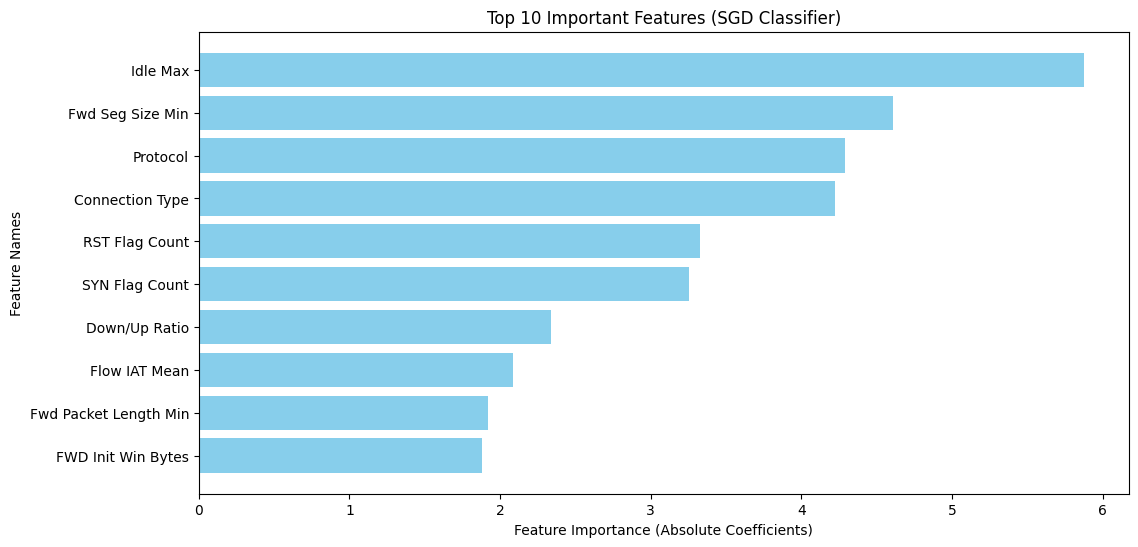

In [18]:
# 🔹 Step 12: Feature Importance Visualization (Fixed)
feature_importance = np.abs(sgd_calibrated.calibrated_classifiers_[0].estimator.coef_).mean(axis=0)
feature_names = np.array(X.columns)  # Get feature names

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# 📊 Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(sorted_features[:10], sorted_importance[:10], color='skyblue')  # Top 10 features
plt.xlabel("Feature Importance (Absolute Coefficients)")
plt.ylabel("Feature Names")
plt.title("Top 10 Important Features (SGD Classifier)")
plt.gca().invert_yaxis()  # Reverse order to match sorted ranking
plt.show()

In [19]:
# 🔹 Step 13: Save Model, Scaler, and Label Encoder
joblib.dump(sgd_calibrated, "sgd_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")
print("Model, scaler, and label encoder saved successfully!")

Model, scaler, and label encoder saved successfully!
